In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from ddpm import DDPM

datasaurus = pd.read_csv("datasaurus.csv")
dino = datasaurus[datasaurus["dataset"] == "dino"]
X = torch.tensor(dino[["x", "y"]].values, dtype=torch.float32)
mean = X.mean(dim=0, keepdim=True)
std = X.std(dim=0, keepdim=True)

# Normalize: (X - mean) / std
X = (X - mean) / std
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=142, shuffle=True)

In [ ]:
net = nn.Sequential(
    nn.Linear(3,128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 2),
)
ddpm = DDPM(1000, net, (2,))
ddpm.train(loader, 20000)


(1000, 2)

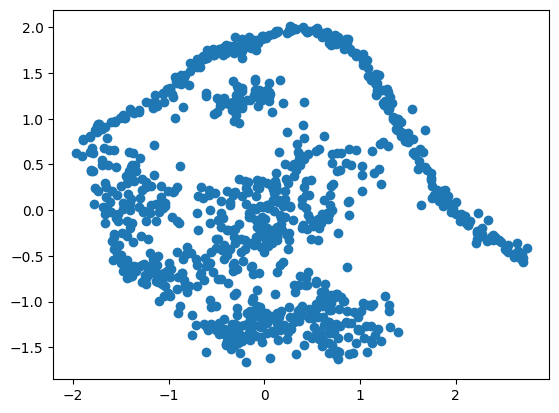

In [ ]:
x = ddpm.sample(1000, eta=1).detach().numpy()
plt.scatter(x[:,0], x[:,1])
x.shape